In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Загрузка данных

In [2]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [3]:
x_train[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

Нормализация

In [4]:
standart_scaler = StandardScaler()
x_train = standart_scaler.fit_transform(x_train)
x_test = standart_scaler.fit_transform(x_test)
print(x_train[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


Построение модели

In [ ]:
model = Sequential()
model.add(Dense(13, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

Обучение

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=1, validation_split=0.1)

Epoch 1/100
363/363 [==============================] - 2s 3ms/step - loss: 546.0466 - mae: 21.4187 - val_loss: 389.3007 - val_mae: 18.5750
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 374.2234 - mae: 16.8743 - val_loss: 198.5623 - val_mae: 12.7120
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 179.1153 - mae: 10.7284 - val_loss: 59.7016 - val_mae: 6.5320
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 72.3349 - mae: 5.9296 - val_loss: 22.1876 - val_mae: 3.6699
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 41.9397 - mae: 4.3603 - val_loss: 21.1359 - val_mae: 3.5429
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 33.4835 - mae: 3.9834 - val_loss: 22.7535 - val_mae: 3.6620
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 29.0999 - mae: 3.7443 - val_loss: 23.8136 - val_mae: 3.6714
Epoch 8/100
363/363 [========================

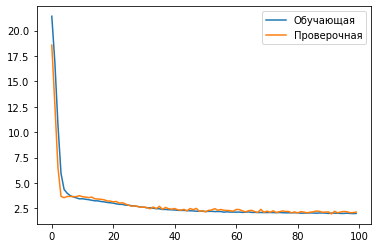

In [ ]:
plt.plot(history.history['mae'], label='Обучающая')
plt.plot(history.history['val_mae'], label='Проверочная')
plt.legend()
plt.show()

Проверка

In [ ]:
mae, mse = model.evaluate(x_test, y_test)
print(mae)
print(mse)

4/4 [==============================] - 0s 3ms/step - loss: 16.8590 - mae: 2.8227
16.859010696411133
2.822674512863159


In [ ]:
n = 1
pred = model.predict(x_test)
print(pred[n][0], ' - ', y_test[n])

18.569702  -  18.8


Подбор гиперпараметров с помощью Keras Tuner

In [5]:
!pip install -U keras-tuner -q
from keras_tuner.tuners import RandomSearch

     |████████████████████████████████| 135 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 36.1 MB/s 


In [6]:
def build_model(hp):
  model_tuner = Sequential()
  activation_choice = hp.Choice('activation', values=['relu', 'sigmoid'])
  model_tuner.add(Dense(units=hp.Int('units_input',
                               min_value=8,
                               max_value=512,
                               step=8),
                  input_dim=x_train.shape[1],
                  activation=activation_choice))
  for i in range(hp.Int('num_layers', 0,2)):
    model_tuner.add(Dense(units=hp.Int('units_'+str(i),
                                 min_value=8,
                                 max_value=512,
                                 step=8),
                    activation=activation_choice))
  model_tuner.add(Dense(1))

  model_tuner.compile(
      optimizer=hp.Choice('optimizer', values=['Adam', 'rmsprop']),
      loss='mse',
      metrics=['mae'])
  
  return model_tuner

In [7]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=100,
    directory='directory'
)

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 512, 'step': 8, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'rmsprop'], 'ordered': False}


In [9]:
tuner.search(
    x_train,
    y_train,
    batch_size=1,
    epochs=100,
    validation_split=0.1
)

Trial 100 Complete [00h 02m 22s]
val_mae: 2.2717671394348145

Best val_mae So Far: 1.3536319732666016
Total elapsed time: 03h 07m 45s


In [11]:
models = tuner.get_best_models(num_models=10)
for m in models:
  m.summary()
  m.evaluate(x_test, y_test)
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 352)               4928      
                                                                 
 dense_1 (Dense)             (None, 472)               166616    
                                                                 
 dense_2 (Dense)             (None, 368)               174064    
                                                                 
 dense_3 (Dense)             (None, 1)                 369       
                                                                 
Total params: 345,977
Trainable params: 345,977
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step - loss: 14.1430 - mae: 2.4733

Model: "sequential"
_________________________________________________________________
 Layer (type) 

In [17]:
tuner.get_best_hyperparameters()[0].values

{'activation': 'relu',
 'units_input': 352,
 'num_layers': 2,
 'optimizer': 'Adam',
 'units_0': 472,
 'units_1': 368}

In [18]:
model_tuner = tuner.get_best_models()[0]

In [19]:
mae, mse = model_tuner.evaluate(x_test, y_test)
print(mae)
print(mse)

4/4 [==============================] - 0s 3ms/step - loss: 14.1430 - mae: 2.4733
14.142967224121094
2.473288059234619


In [22]:
n = 5
pred = model_tuner.predict(x_test)
print(pred[n][0], ' - ', y_test[n])

24.376307  -  24.5
